In [2]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from typing import Tuple

In [26]:
sns.set_theme()
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica",
    # "font.title" : 11,
    # "font.axes" : 11,
    # "font.xtick" : 9,
    # "font.ytick" : 9,
    # "font.legend" : 9
    "font.size" : 11
})


In [4]:
def rotate_opt(
    data: np.ndarray, return_x: bool = False
) -> "tuple[np.ndarray, Tuple[np.ndarray, float]]":
    """Rotates ``data`` so that all the signal is in the I quadrature (real part).

    Args:
        data: ``dtype`` should be ``complex128``.
        return_x: if :obj:`True`, return also the angle by which ``data`` was rotated.

    Returns:
        ``data * np.exp(1j * x)``, with ``x`` such that ``np.std(ret.imag)`` is minimum.
        ``dtype=complex128``.

        If ``return_x=True``, also return the angle ``x``.
    """
    # calculate the variance in steps of 1 deg
    N = 360
    _var = np.zeros(N)
    for ii in range(N):
        _data = data * np.exp(1j * 2 * np.pi / N * ii)
        _var[ii] = np.var(_data.imag)

    # the variance goes like cos(x)**2
    # FFT and find the phase at frequency "2"
    fft = np.fft.rfft(_var) / N
    # first solution
    x_fft1 = -np.angle(fft[2])  # compensate for measured phase
    x_fft1 -= np.pi  # we want to be at the minimum of cos(2x)
    x_fft1 /= 2  # move from frequency "2" to "1"
    # there's a second solution np.pi away (a minus sign)
    x_fft2 = x_fft1 + np.pi

    # convert to +/- interval
    x_fft1 = to_pm_pi(x_fft1)
    x_fft2 = to_pm_pi(x_fft2)
    # choose the closest to zero
    if np.abs(x_fft1) < np.abs(x_fft2):
        x_fft = x_fft1
    else:
        x_fft = x_fft2

    # rotate the data and return a copy
    data = data * np.exp(1j * x_fft)
    if return_x:
        return data, x_fft
    else:
        return data

def to_pm_pi(phase: float) -> float:
    """Converts a phase in radians into the [-π, +π) interval.

    Args:
        phase
    """
    return (phase + np.pi) % (2 * np.pi) - np.pi

(81, 1)
(81, 1)
[0.2242155473349254, array([0.3]), -1.5707963267948966, 0.1121077736674627]


c:\Users\albin\anaconda3\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


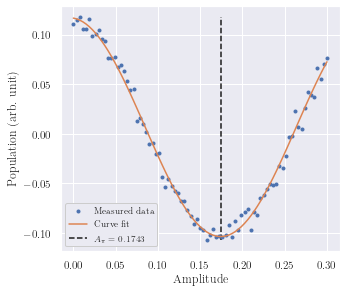

In [31]:
# Load data 
# This is the data from the second run, t = 100 ns, but shorter span to get better fit
data = np.load(r"C:\Users\albin\Documents\GitHub\lab_report_MCC185\Data\2023-10-05-0926_Rabi_measurement.npz")

# To figure out which keys to use retrieve the data
# keys = list(data.keys())
# print(keys)

control_amp = data['control_amp'] # Sweeping the amplitude of the pi pulse
xdata = control_amp

# y-data, proportional to the population of |0>
demod_I_p = data['demod_I_p']
demod_Q_p = data['demod_Q_p']
data_matched = rotate_opt(demod_I_p + 1j * demod_Q_p)
ydata = np.real(data_matched)
ydata = np.reshape(ydata,(81,1))
print(ydata.shape)
xdata = np.reshape(xdata,(81,1))
print(xdata.shape)

# Plotting
plt.figure(figsize=(5,4.5))

plt.plot(xdata,ydata,'.',label="Measured data")

# Fitting - this code is copied from the Rabi measurement file
import scipy.optimize as opt
nr1 = 1 # seems to be related to how many pulses we do, not really sure

def func(t, A, T, phi, B):
    return A * np.sin(2 * np.pi * t / T + phi) + B


#ydata = np.real(data).T
ydata = ydata[:,nr1-1]
p0 = [(np.max(ydata) - np.min(ydata)), np.abs(2 * (xdata[np.argmax(ydata)] - xdata[np.argmin(ydata)])), -np.pi / 2,
        (np.max(ydata) - np.min(ydata)) / 2]
print(p0)
popt, pcov = opt.curve_fit(func, control_amp, ydata, p0=p0,
                            bounds=([-np.inf, 0, -np.pi, -np.inf], [np.inf, np.inf, np.pi, np.inf]))
plt.plot(control_amp, func(control_amp, *popt),label="Curve fit")
plt.vlines(0.5 * (popt[1]) - (popt[2] + np.pi / 2) / (2 * np.pi) * (popt[1]) + (nr1-1)*popt[1], np.min(ydata), np.max(ydata),
            colors='k', linestyles='dashed',
            label=r'$A_\pi=%.4f $' % (0.5 * (popt[1]) - (popt[2] + np.pi / 2) / (2 * np.pi) * (popt[1]) + (nr1-1)*popt[1]))
plt.legend(framealpha=1,loc="lower left",fontsize=9)
plt.xlabel("Amplitude")
plt.ylabel("Population (arb. unit)")

plt.savefig("Rabi_1.pdf", format="pdf", bbox_inches="tight")

plt.show()

(81, 1)
(81, 1)
[0.22689876472489023, array([0.105]), -1.5707963267948966, 0.11344938236244512]


c:\Users\albin\anaconda3\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


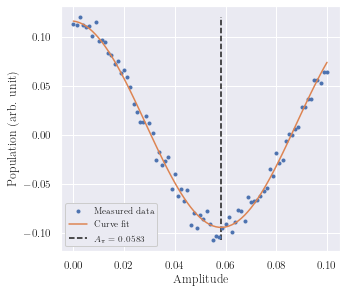

In [32]:
# Load data 
# This is the data from the third run, t = 300 ns
data = np.load(r"C:\Users\albin\Documents\GitHub\lab_report_MCC185\Data\2023-10-05-0928_Rabi_measurement.npz")

# To figure out which keys to use retrieve the data
# keys = list(data.keys())
# print(keys)

control_amp = data['control_amp'] # Sweeping the amplitude of the pi pulse
xdata = control_amp

# y-data, proportional to the population of |0>
demod_I_p = data['demod_I_p']
demod_Q_p = data['demod_Q_p']
data_matched = rotate_opt(demod_I_p + 1j * demod_Q_p)
ydata = np.real(data_matched)
ydata = np.reshape(ydata,(81,1))
print(ydata.shape)
xdata = np.reshape(xdata,(81,1))
print(xdata.shape)

# Plotting
plt.figure(figsize=(5,4.5))

plt.plot(xdata,ydata,'.',label="Measured data")

# Fitting - this code is copied from the Rabi measurement file
import scipy.optimize as opt
nr1 = 1 # seems to be related to how many pulses we do, not really sure

def func(t, A, T, phi, B):
    return A * np.sin(2 * np.pi * t / T + phi) + B


#ydata = np.real(data).T
ydata = ydata[:,nr1-1]
p0 = [(np.max(ydata) - np.min(ydata)), np.abs(2 * (xdata[np.argmax(ydata)] - xdata[np.argmin(ydata)])), -np.pi / 2,
        (np.max(ydata) - np.min(ydata)) / 2]
print(p0)
popt, pcov = opt.curve_fit(func, control_amp, ydata, p0=p0,
                            bounds=([-np.inf, 0, -np.pi, -np.inf], [np.inf, np.inf, np.pi, np.inf]))
plt.plot(control_amp, func(control_amp, *popt),label="Curve fit")
plt.vlines(0.5 * (popt[1]) - (popt[2] + np.pi / 2) / (2 * np.pi) * (popt[1]) + (nr1-1)*popt[1], np.min(ydata), np.max(ydata),
            colors='k', linestyles='dashed',
            label=r'$A_\pi=%.4f $' % (0.5 * (popt[1]) - (popt[2] + np.pi / 2) / (2 * np.pi) * (popt[1]) + (nr1-1)*popt[1]))
plt.legend(framealpha=1,loc="lower left",fontsize=9)
plt.xlabel("Amplitude")
plt.ylabel("Population (arb. unit)")

plt.savefig("Rabi_2.pdf", format="pdf", bbox_inches="tight")

plt.show()

(81, 1)
(81, 1)
[0.23301952998323877, array([0.018]), -1.5707963267948966, 0.11650976499161939]


c:\Users\albin\anaconda3\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


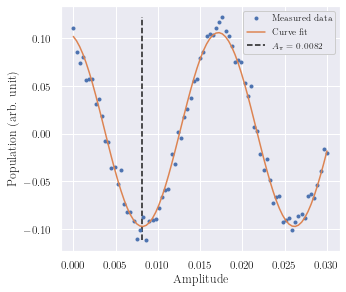

In [34]:
# Load data 
# This is the data from the third run, t = 300 ns
data = np.load(r"C:\Users\albin\Documents\GitHub\lab_report_MCC185\Data\2023-10-05-0940_Rabi_measurement.npz")

# To figure out which keys to use retrieve the data
# keys = list(data.keys())
# print(keys)

control_amp = data['control_amp'] # Sweeping the amplitude of the pi pulse
xdata = control_amp

# y-data, proportional to the population of |0>
demod_I_p = data['demod_I_p']
demod_Q_p = data['demod_Q_p']
data_matched = rotate_opt(demod_I_p + 1j * demod_Q_p)
ydata = np.real(data_matched)
ydata = np.reshape(ydata,(81,1))
print(ydata.shape)
xdata = np.reshape(xdata,(81,1))
print(xdata.shape)

# Plotting
plt.figure(figsize=(5,4.5))

plt.plot(xdata,ydata,'.',label="Measured data")

# Fitting - this code is copied from the Rabi measurement file
import scipy.optimize as opt
nr1 = 1 # seems to be related to how many pulses we do, not really sure

def func(t, A, T, phi, B):
    return A * np.sin(2 * np.pi * t / T + phi) + B


#ydata = np.real(data).T
ydata = ydata[:,nr1-1]
p0 = [(np.max(ydata) - np.min(ydata)), np.abs(2 * (xdata[np.argmax(ydata)] - xdata[np.argmin(ydata)])), -np.pi / 2,
        (np.max(ydata) - np.min(ydata)) / 2]
print(p0)
popt, pcov = opt.curve_fit(func, control_amp, ydata, p0=p0,
                            bounds=([-np.inf, 0, -np.pi, -np.inf], [np.inf, np.inf, np.pi, np.inf]))
plt.plot(control_amp, func(control_amp, *popt),label="Curve fit")
plt.vlines(0.5 * (popt[1]) - (popt[2] + np.pi / 2) / (2 * np.pi) * (popt[1]) + (nr1-1)*popt[1], np.min(ydata), np.max(ydata),
            colors='k', linestyles='dashed',
            label=r'$A_\pi=%.4f $' % (0.5 * (popt[1]) - (popt[2] + np.pi / 2) / (2 * np.pi) * (popt[1]) + (nr1-1)*popt[1]))
plt.legend(framealpha=1,loc="upper right",fontsize=9)
plt.xlabel("Amplitude")
plt.ylabel("Population (arb. unit)")

plt.savefig("Rabi_3.pdf", format="pdf", bbox_inches="tight")

plt.show()